# Tutorial 4 - Hairpin first passage times

Here we ask Multistrand to simulate the folding of an open strand into a hairpin, and stop when it's done.  This mode, **First Passage Time Mode**, requires us to specific a start state and a recognizable stop condition (i.e. entering a macrostate), and Multistrand returns the total time it took.  Running a lot of simulations and plotting histograms and completion fractions can provide insight into the process -- and its stochastic variability.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

from multistrand.objects import *
from multistrand.options import Options
from multistrand.system import SimSystem

#### This is first passage time

In [2]:
# for StopCondition and Macrostate definitions:
Exact_Macrostate = 0   # match a secondary structure exactly (i.e. any system state that has a complex with this exact structure)
Bound_Macrostate = 1   # match any system state in which the given strand is bound to another strand
Dissoc_Macrostate = 2  # match any system state in which there exists a complex with exactly the given strands, in that order
Loose_Macrostate = 3   # match a secondary structure with "don't care"s, allowing a certain number of disagreements
Count_Macrostate = 4   # match a secondary structure, allowing a certain number of disagreements
# see Schaeffer's PhD thesis, chapter 7.2, for more information

In [3]:
def setup_options_hairpin(trials, stem_seq, hairpin_seq):

    # Define the domains
    stem = Domain(name="stem",sequence=stem_seq,length=len(stem_seq))
    hairpin = Domain(name="hairpin", sequence=hairpin_seq,length=len(hairpin_seq))
    s = stem + hairpin + stem.C
    
    # We give domain-level structures for the open and closed hairpin configurations
    start_complex = Complex(strands=[s], structure="...")
    stop_complex  = Complex(strands=[s], structure="(.)")
    full_sc       = StopCondition( "CLOSED", [(stop_complex,Exact_Macrostate,0)])
    # Note: unlike in Transition Mode, in First Passage Time Mode, no "stop:" prefix is needed in the macrostate name
    # in order for the StopCondition to trigger the end of the simulation.

    o = Options(simulation_mode="First Passage Time",parameter_type="Nupack",substrate_type="DNA", temperature=310.15,
                num_simulations = trials, simulation_time=0.1, rate_scaling='Calibrated', verbosity=0,
                start_state=[start_complex], stop_conditions=[full_sc])

    return o

The simulation is easy. There's more fuss and bother to define how to plot the results.

In [4]:
def plot_histograms( result_lists, colors=['b','r','c','m','g','k'], figure=1, labels=None ):
    times = []
    for n in range(len(result_lists)):
        times.append(1e6* np.array([ i.time for i in result_lists[n] ]))    # convert from seconds to microseconds units.

    min_time = np.min( [np.min(times[n]) for n in range(len(result_lists)) ] )
    max_time = np.max( [np.max(times[n]) for n in range(len(result_lists)) ] )

    plt.figure( figure )
    plt.hold(False)
    for n in range(len(result_lists)):
        plt.hist( times[n], 50, range=(min_time,max_time), color = colors[n], label=labels[n], rwidth=(1-n*1.0/len(result_lists)) )
        plt.hold(True)

    plt.title("Folding times for two hairpin sequences")
    plt.xlabel("First Passage Time (us)",fontsize='larger')
    plt.ylabel("# of Trajectories",fontsize='larger')
    plt.yticks(fontsize='larger',va='bottom')
    plt.xticks(fontsize='larger')
    plt.legend(loc=0)
    plt.show()

def plot_completion_graph( result_lists, colors=['b','r','c','m','g','k'], figure=1, labels=None ):
    times = []
    percents = []
    if labels==None:
        labels=[str(n) for n in range(1,1+len(result_lists))]
    if len(labels) < len(colors):
        colors = colors[:len(labels)]

    for rl in result_lists:
        n = len(rl)
        t = [i.time for i in rl]
        t.sort()
        times.append(np.array(t))

        p = np.array(range(1,len(t)+1))
        p = 100 * p / n  # percentage of all trials
        percents.append( p )

    plt.figure( figure )
    plt.hold(False)

    for t,p,c,label in zip(times,percents,colors,labels):
        plt.plot( 1e6 * t, p, color = c, linewidth=2.0, label=label )
        plt.hold(True)

    plt.xlabel("Simulation Time (us)",fontsize='larger')
    plt.ylabel("% of Trajectories Complete",fontsize='larger')
    plt.yticks([0,20,40,60,80,100],("0%","20%","40%","60%","80%","100%"),fontsize='larger',va='bottom')
    plt.xticks(fontsize='larger')
    plt.title( "Percentage of Total Trajectories Complete by a Given Time" )
    plt.legend(loc=0)
    plt.show()

In [5]:
# First Passage Time Mode doesn't store the full trajectory.  But it gives the random number seed used on a given simulation.
# So we can re-run interesting simulations to see what happened.
# Here, we also show how to run a Trajectory Mode simulation with a StopCondition (rather than time-out).
def show_interesting_trajectories( result_lists, seqs, type='fastest' ):
    mintimes = []
    maxtimes = []
    slowseeds = []
    fastseeds = []
    for n in range(len(result_lists)):
        times = 1e6* np.array([ i.time for i in result_lists[n] ])    # convert from seconds to microseconds units.
        slowseeds.append( result_lists[n][np.argmax( times )].seed )  # find the seed used for the slowest simulation
        fastseeds.append( result_lists[n][np.argmin( times )].seed )  # find the seed used for the fastest simulation
        mintimes.append( np.min( times ) )
        maxtimes.append( np.max( times ) )

    # taken from hairpin_trajectories.py
    def print_trajectory(o):
        print o.full_trajectory[0][0][3]   # the strand sequence
        print o.start_state[0].structure
        for i in range(len(o.full_trajectory)):
            time = 1e6* o.full_trajectory_times[i]
            state = o.full_trajectory[i][0]
            struct = state[4]
            dG = state[5]
            print struct + ' t=%11.9f microseconds, dG=%6.2f kcal/mol' % (time, dG)

    # take a look at the fastest folds.  to take a look at the more interesting slowest folds,
    # change "mintimes" to "maxtimes" and change "fastseeds" to "slowseeds"; do this based on 'type' argument
    seeds = fastseeds if type=='fastest' else slowseeds
    times = mintimes if type=='fastest' else maxtimes
    for (seq,seed,time) in zip(seqs,seeds,times):
        s1 = Strand(name="hairpin", sequence=seq)
        c1 = Complex( strands=[s1], structure=16*'.' )             # hard-coded length 16
        c2 = Complex( strands=[s1], structure="((((((....))))))")  # hard-coded stem length 6, loop length 4
        sc  = StopCondition( "CLOSED", [(c2,Exact_Macrostate,0)])
        # For future reference, StopConditions and Macrostates (same thing) are provided as a list of match conditions,
        # all of which must be matched.  I.e. there is an implicit AND being evaluated.  E.g. 
        # sc = StopCondition( "EXAMPLE", [(c2,Loose_Macrostate,8), (c1,Loose_Macrostate,4)]
        # would specify the intersection of those two macrostates, i.e. any 2 base pairs of the helix (and maybe more).

        o = Options(temperature=310.15, dangles='Some', start_state = [c1], 
            simulation_time = 0.1,  # 0.1 seconds  (lots more time than hairpin_trajectories, to accommodate slow folds)
            num_simulations = 1,  # don't play it again, Sam
            output_interval = 1,  # record every single step
            rate_method = 'Metropolis', # the default is 'Kawasaki' (numerically, these are 1 and 2 respectively)
            rate_scaling = 'Calibrated', # this is the same as 'Default'.  'Unitary' gives values 1.0 to both.  
            simulation_mode = 'Trajectory')  # numerically 128.  See interface/_options/constants.py for more info about all this.
        o.stop_conditions=[sc]               # don't wait for the time-out
        o.initial_seed = seed                # start with the same random seed as before...  

        s = SimSystem(o)
        s.start()
        print_trajectory(o)        
        print "Original run's time: %g microseconds" % time

In [6]:
def run_sims():
    print "Performing simulations..."
    # compare closing of stems based on possible kinetic traps
    o1 = setup_options_hairpin(trials=1000, stem_seq = "GCATGC", hairpin_seq="TTTT")  # 2-base misaligned GC pairing possible
    o2 = setup_options_hairpin(trials=1000, stem_seq = "GGCGGC", hairpin_seq="TTTT")  # 3-base misaligned GGC pairing possible
    o3 = setup_options_hairpin(trials=1000, stem_seq = "GCCGCG", hairpin_seq="TTTT")  # strong stem, but no significant misaligned pairing
    o4 = setup_options_hairpin(trials=1000, stem_seq = "ATTATA", hairpin_seq="TTTT")  # weak stem, no significant misaligned pairing

    s=SimSystem(o1)
    s.start()
    s=SimSystem(o2)
    s.start()
    s=SimSystem(o3)
    s.start()
    s=SimSystem(o4)
    s.start()
    # all these simulations are at the same join_concentration and temperature,
    # so there's no need to re-initialize the energy model before each one.


    all_results = [o.interface.results for o in [o1, o2, o3, o4]]
    all_seqs    = [o.start_state[0].sequence for o in [o1, o2, o3, o4]]

    print "Plotting results..."
    plot_histograms(all_results, figure=1, labels=all_seqs)
    plot_completion_graph(all_results, figure=2, labels=all_seqs)
    # conclusions: 
    #    weak stem forms slowly, but without traps.
    #    stronger stems form quickly, but if 3-base misalignment is possible, it may take a long time

    special = 'fastest'   # or 'slowest', if you wish, but these trajectories involve many many steps!
    print "Showing the %s trajectories for each hairpin sequence..." % special
    show_interesting_trajectories(all_results, all_seqs, special)


OK, time to actually run the simulations.

Performing simulations...
Plotting results...


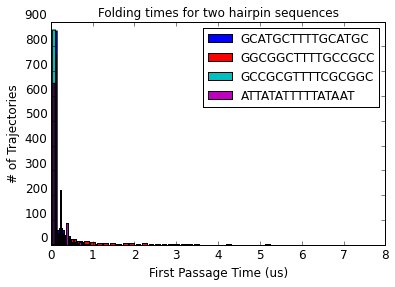

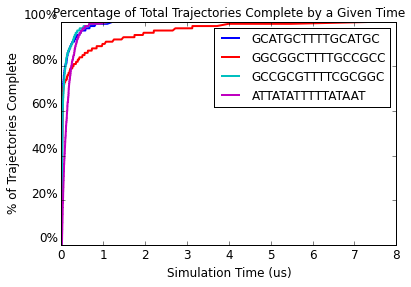

Showing the fastest trajectories for each hairpin sequence...
GCATGCTTTTGCATGC
................
(..............) t=0.001031155 microseconds, dG=  3.60 kcal/mol
((............)) t=0.001045078 microseconds, dG=  1.26 kcal/mol
(((..........))) t=0.001374474 microseconds, dG= -0.17 kcal/mol
(((.(......).))) t=0.001512538 microseconds, dG=  0.31 kcal/mol
(((.((....)).))) t=0.001559573 microseconds, dG= -2.83 kcal/mol
((((((....)))))) t=0.001590837 microseconds, dG= -6.16 kcal/mol
Original run's time: 0.00159084 microseconds
GGCGGCTTTTGCCGCC
................
.....(....)..... t=0.000096955 microseconds, dG=  1.15 kcal/mol
..(..(....)..).. t=0.000260229 microseconds, dG=  1.85 kcal/mol
.((..(....)..)). t=0.000565808 microseconds, dG= -0.31 kcal/mol
.((.((....)).)). t=0.000601655 microseconds, dG= -2.25 kcal/mol
.(((((....))))). t=0.000699386 microseconds, dG= -7.26 kcal/mol
((((((....)))))) t=0.000975618 microseconds, dG= -8.23 kcal/mol
Original run's time: 0.000975618 microseconds
GCCGCGTTTTC

In [7]:
run_sims()